# Create resampling of available replicate data to explore effects of noise

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import openensembles as oe
import numpy as np

fileName = '../data/experiment.1381.annotated_misTrypsRemoved.txt'
df = pd.read_csv(fileName, sep='\t')

#keep the data and the standard deviations in different dataframes and then instantiate data objects with resampling, 
# ultimately merging them together. 

dataCols  = ['average:data:time(min):0', 'average:data:time(min):1', 'average:data:time(min):2',
       'average:data:time(min):4', 'average:data:time(min):8',
       'average:data:time(min):16', 'average:data:time(min):32']
stdevCols = ['average:stddev:time(min):0', 'average:stddev:time(min):1',
       'average:stddev:time(min):2', 'average:stddev:time(min):4',
       'average:stddev:time(min):8', 'average:stddev:time(min):16',
       'average:stddev:time(min):32']
descriptiveCols = ['gene', 'mod_sites'] #we don't need ALL the metadata, so we'll just start with this

colsToKeep = descriptiveCols + dataCols
master_df = df[colsToKeep]
x = [0, 1, 2, 4, 8, 16, 32]

stdev_df = df[stdevCols]
stdev_df = stdev_df[stdevCols].astype(float)

#This is the data object with data exactly as it stands with means. We'll create
# a list of new data objects that have resampled data representations 
d = oe.data(master_df, x)

In [3]:
#create new data objects, resampling each time point for each object according to their mean and stdev 
# using a normal distribution
numRepeats = 500
d_arr = []
for i in range(0, numRepeats):
    df_temp = master_df.copy()
    #get a series from data and make new data column 
    for index, row in df_temp.iterrows():
        for data in dataCols:
            stdevCol = data.replace('data', 'stddev')
            if stdev_df.ix[index,stdevCol] > 0:
                df_temp.ix[index, data] = np.random.normal(row[data], stdev_df.ix[index,stdevCol])
            else:
                df_temp.ix[index,data] = row[data]
    d_temp = oe.data(df_temp, x)
    d_arr.append(d_temp)



## Cluster all resampled data for an ensemble solution

In [4]:
transdict = d.merge(d_arr) #merge all data matrices together (could also just iterate through )

In [5]:
K = 10
c = oe.cluster(d) 

for name in d.D.keys():
    c.cluster(name, 'kmeans', 'kmeans_'+name, K)
    
    

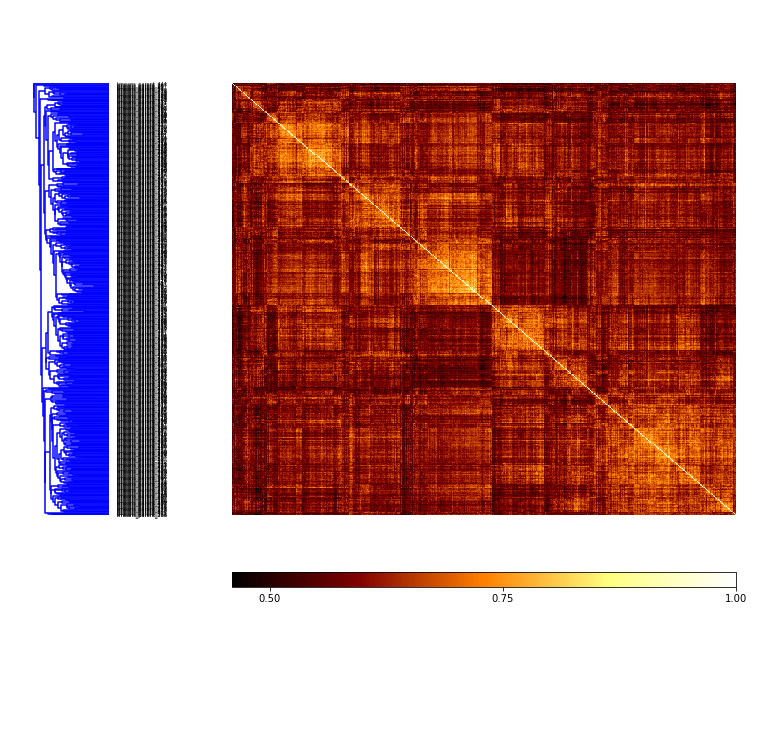

In [6]:
# how do all solutions compare?
MI = c.MI(MI_type='normalized')
MI.plot()

In [7]:
coMat = c.co_occurrence_matrix('parent')

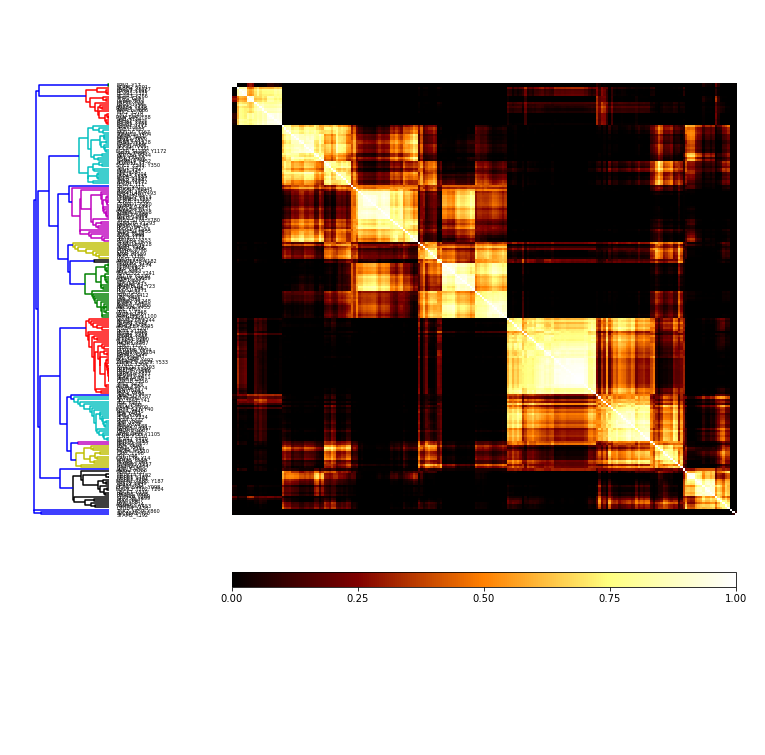

In [8]:
labels = d.df['gene'] + '_' + d.df['mod_sites']
coMat.plot(threshold=0.5, label_vec = list(labels))